In [4]:
using AutomotiveDrivingModels
using AutoViz
using AutomotiveSensors
using AutomotivePOMDPs
using Parameters
using StaticArrays
using ProfileView

using GridInterpolations 
using POMDPs
using POMDPToolbox
using QMDP
using JLD
using Reel
using Revise


include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")



include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")


animate_record (generic function with 2 methods)

In [32]:
include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")

include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")


#qmdp_policy = load("policy.jld")["policy"];


pomdp = SingleOCFPOMDP()
updater = SingleOCFUpdater(pomdp)

params = CrosswalkParams()
params.obstacles_visible = false

obstacle_1 = ConvexPolygon([VecE2(34, -1.5), VecE2(34, -4.5), VecE2(46.5, -4.5), VecE2(46.5, -1.5)],4)
obstacle_2 = ConvexPolygon([VecE2(34, +4.5), VecE2(34, +7.5), VecE2(46.5, +7.5), VecE2(46.5, +4.5)],4)
params.obstacles = [obstacle_1, obstacle_2]
#params.obstacles = [obstacle_2]

env = CrosswalkEnv(params)
pomdp.env = env



ego_v = 10.73
ped_v = 5.4/3.6
hitpoint = 0             # 50: middle, 100: left corner, 0: right corner
ped_theta = π/2


# fix values
ped_x = 50.0
ped_y_start = -5.0
ego_y = 0.0


ped_y_offset_hitpoint = VehicleDef().width * hitpoint / 100 - VehicleDef().width/2
ped_y_end = ped_y_offset_hitpoint
ped_t_collision = (ped_y_end - ped_y_start) / ped_v; 
ego_x = ped_x - ego_v * ped_t_collision - VehicleDef().length/2;

if ( false )
    ego_v = 0.0
    ego_x = 20
    ped_x = 30
    ped_y_start = -2.0
    ped_v = 0.0
end

ped_y_start = -7.0
ped_v = 2.0

# Car definition
ego_initial_state = VehicleState(VecSE2(ego_x, ego_y, 0.), env.roadway.segments[1].lanes[1], env.roadway, ego_v)
ego = Vehicle(ego_initial_state, VehicleDef(), 1)

# Pedestrian definition using our new Vehicle definition
ped_initial_state = VehicleState(VecSE2(ped_x,ped_y_start,ped_theta), env.crosswalk, env.roadway, ped_v)
ped = Vehicle(ped_initial_state, AutomotivePOMDPs.PEDESTRIAN_DEF, 2)

scene = Scene()
push!(scene, ego)
push!(scene, ped)



cam = FitToContentCamera(0.);
timestep = 0.2


pos_noise = 0.001
vel_noise = 0.001
false_positive_rate = 0.00
false_negative_rate = 0.00
rng = MersenneTwister(1);
sensor = AutomotiveSensors.GaussianSensor(AutomotiveSensors.LinearNoise(10, pos_noise, 0.00), 
                 AutomotiveSensors.LinearNoise(10, vel_noise, 0.00), false_positive_rate, false_negative_rate, rng) 



# define a model for each entities present in the scene
models = Dict{Int, DriverModel}()

ego_id = 1
ped_id = 2

obs = SingleOCFState(0.0, ego_v, ped_x-ego_x, ped_y_start, ped_theta, ped_v)
println(obs)

pomdp.ego_vehicle = ego
models[ego_id] = FrenetPedestrianPOMDP(a=LatLonAccel(0.0, 0.0),env=env,sensor=sensor, obstacles=env.obstacles, timestep=timestep,
    env=env,
    pomdp=pomdp,
  #  policy=qmdp_policy,
    updater=updater,
    ego_vehicle=ego,
    desired_velocity=ego_v,
    b=initBeliefAbsentPedestrian(pomdp, ego_y, ego_v)
)
models[ego_id].pomdp.desired_velocity = ego_v
models[ego_id].pomdp.ΔT = timestep

models[ped_id] = ConstantPedestrian(v_desired=ped_v, dawdling_amp=0.001) # dumb model

nticks = 20
rec = SceneRecord(nticks+1, timestep)

risk = Float64[]
sensor_observations = [Vehicle[]]
belief = SingleOCFBelief[]
ego_vehicle = Vehicle[]
action_pomdp = SingleOCFAction[]

obs_callback = (ObservationCallback(risk,sensor_observations, belief, ego_vehicle, action_pomdp),)

tic()
simulate!(rec, scene, env.roadway, models, nticks, obs_callback)
toc()




SingleOCFState(0.0, 10.73, 31.328666666666663, -7.0, 1.5707963267948966, 2.0)
--------------------------POMDP high level planner----------------------- t: 0.0
EGO: x/y:18.671333333333337 / 0.0 v: 10.73
PED: x/y: 50.00038239596779 / -7.000597634476728 v: 1.9999895547553626
delta_s: 31.329049062634454 delta_t: -7.000597634476728
Observation cont: SingleOCFState(0.0, 10.73, 31.329049062634454, -7.000597634476728, 1.5707963267948966, 1.9999895547553626)
init belief absent
--------------------------POMDP high level planner----------------------- t: 0.2
EGO: x/y:20.817333333333337 / 0.0 v: 10.73
PED: x/y: 50.001886359056506 / -6.597704912176164 v: 1.4977329136511994
delta_s: 29.184553025723165 delta_t: -6.597704912176164
Observation cont: SingleOCFState(0.0, 10.73, 29.184553025723165, -6.597704912176164, 1.5707963267948966, 1.4977329136511994)
action before update: SingleOCFAction(0.0, 0.0)
Pedestrian is absent: SingleOCFState(0.0, 10.5, -10.0, -10.0, 0.0, 0.0)
b-length: 1
------------------

4.422344334

In [33]:
duration, fps, render_hist = animate_record(rec, timestep, env, sensor, sensor_observations, risk, belief, ego_vehicle, action_pomdp, CarFollowCamera(2,10.0))
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("/tmp/tmpiI89Nq", 0x000000000000000f, 5.0, nothing)

In [20]:
bel = belief[end]
for b in bel
    println(b)
end

SingleOCFState(0.0, 10.5, 0.0, 0.0, 1.57, 0.0)=>7.867645601073621e-14
SingleOCFState(0.0, 10.5, 1.0, 0.0, 1.57, 0.0)=>1.711044426383158e-11
SingleOCFState(0.0, 10.5, 2.0, 0.0, 1.57, 0.0)=>9.134368434465483e-12
SingleOCFState(0.0, 10.5, 3.0, 0.0, 1.57, 0.0)=>3.1952807197693752e-19
SingleOCFState(0.0, 10.5, 0.0, 1.0, 1.57, 0.0)=>3.487260578382111e-7
SingleOCFState(0.0, 10.5, 1.0, 1.0, 1.57, 0.0)=>0.0001228140954851975
SingleOCFState(0.0, 10.5, 2.0, 1.0, 1.57, 0.0)=>7.709256702615503e-5
SingleOCFState(0.0, 10.5, 3.0, 1.0, 1.57, 0.0)=>2.7068526900662372e-12
SingleOCFState(0.0, 10.5, 4.0, 1.0, 1.57, 0.0)=>6.800782861249642e-39
SingleOCFState(0.0, 10.5, 0.0, 2.0, 1.57, 0.0)=>5.22750705000759e-9
SingleOCFState(0.0, 10.5, 1.0, 2.0, 1.57, 0.0)=>0.00020424201557125442
SingleOCFState(0.0, 10.5, 2.0, 2.0, 1.57, 0.0)=>0.0006629393917155462
SingleOCFState(0.0, 10.5, 3.0, 2.0, 1.57, 0.0)=>2.308506264447756e-11
SingleOCFState(0.0, 10.5, 4.0, 2.0, 1.57, 0.0)=>5.799950704302663e-38
SingleOCFState(0.0, 1

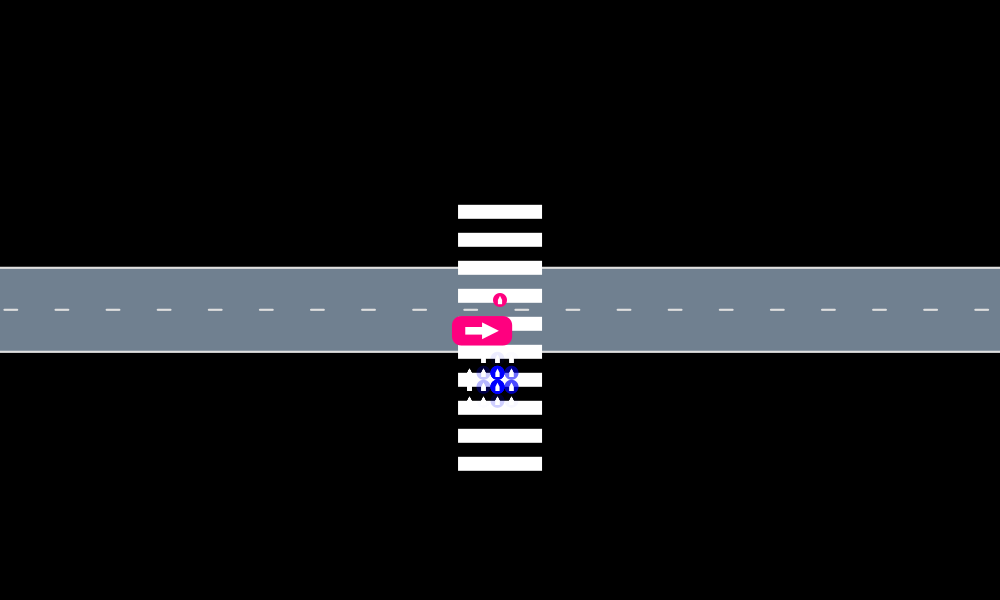

In [30]:
i = 3
scene = rec[0]
bel = belief[i]
belief_overlay = BeliefOverlay(belief=bel, ego_vehicle=ego_vehicle[i])

AutoViz.render(rec[-1], env, SceneOverlay[belief_overlay], cam=CarFollowCamera(2,14.0))

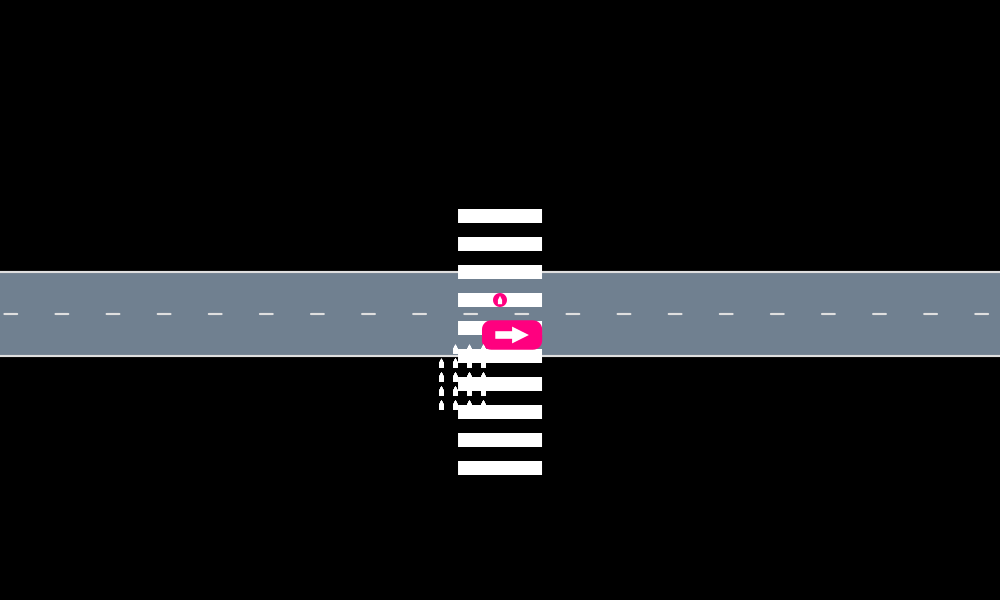

In [31]:
include("../src/pedestrian_crossing/pomdp_types.jl")
include("../src/pedestrian_crossing/spaces.jl")
include("../src/pedestrian_crossing/transition.jl")
include("../src/pedestrian_crossing/observation.jl")
include("../src/pedestrian_crossing/belief.jl")

include("../src/pedestrian_crossing/frenet_pedestrian_pomdp.jl")

next_states = SingleOCFState[]
for (s, prob) in weighted_iterator(bel)
    td = transition(pomdp, s, SingleOCFAction(-2.0, 0.0), pomdp.ΔT)
    for sp in td.vals
        push!(next_states, sp)
    end
end
pred_bel = SparseCat(next_states, normalize(ones(length(next_states)),1))
belief_overlay = BeliefOverlay(belief=pred_bel, ego_vehicle=ego_vehicle[i])
fake_ego = VehicleState()
scene = Scene()
AutoViz.render(rec[0], env, SceneOverlay[belief_overlay], cam=CarFollowCamera(2,14.0))

In [46]:
pomdp

SingleOCFPOMDP
  env: AutomotivePOMDPs.CrosswalkEnv
  ego_type: AutomotiveDrivingModels.VehicleDef
  ped_type: AutomotiveDrivingModels.VehicleDef
  longitudinal_actions: Array{Float64}((5,)) [1.0, 0.0, -1.0, -2.0, -4.0]
  lateral_actions: Array{Float64}((3,)) [1.0, 0.0, -1.0]
  ΔT: Float64 0.5
  PED_A_RANGE: Array{Float64}((5,)) [-2.0, -1.0, 0.0, 1.0, 2.0]
  PED_THETA_NOISE: Array{Float64}((3,)) [-0.195, 0.0, 0.195]
  PED_SAFETY_DISTANCE: Float64 1.0
  EGO_Y_MIN: Float64 -1.0
  EGO_Y_MAX: Float64 1.0
  EGO_Y_RANGE: Array{Float64}((1,)) [0.0]
  EGO_V_MIN: Float64 0.0
  EGO_V_MAX: Float64 14.0
  EGO_V_RANGE: Array{Float64}((29,)) [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0]
  S_MIN: Float64 0.0
  S_MAX: Float64 50.0
  S_RANGE: Array{Float64}((51,)) [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0  …  41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0]
  T_MIN: Float64 -5.0
  T_MAX: Float64 5.0
  T_RANGE: Array{F

In [55]:
pomdp.env.params.obstacles_visible

false